# Compute the PCA eigen-lightcurves
### AKA "Cotrending-basis-vectors"

In this notebook we develop PCA eigen-lightcurves, also known as "Cotrending-basis-vectors".  These experimentally-derived lightcurves show the type of variation common across disparate targets, suggesting that these trends arise from instrumental effects, and not a conspiracy of galaxies to vary in phase at the exact same moments.  

The Kepler pipeline processing provides these "Cotrending-basis vectors", but C16 has not yet gone through the pipeline.  So let's compute them on our own!

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from lightkurve import KeplerTargetPixelFile
import glob

We'll need Principal Component Analysis (PCA).  For an explanation of PCA applied to astronomy see [this video](https://www.youtube.com/watch?v=CvBCmWc8iBE) or [this book](https://press.princeton.edu/titles/10159.html).

In [2]:
from sklearn.decomposition import PCA

In [3]:
n_tpfs = 8380
n_cadences = 3888

In [4]:
x0s_array = np.load('../data/C16_raw/x0s_array.npy')
y0s_array = np.load('../data/C16_raw/y0s_array.npy')
lc_array = np.load('../data/C16_raw/lc_array.npy')
sigma_clip_array = np.load('../data/C16_raw/sigma_clip_array.npy')
n_pix_ap = np.load('../data/C16_raw/n_pix_ap.npy')
n_pix_bg = np.load('../data/C16_raw/n_pix_bg.npy')
ch_array = np.load('../data/C16_raw/ch_array.npy')
fail_array = np.load('../data/C16_raw/fail_array.npy')

We'll eventually want to drop the thruster-firing cadences:

In [5]:
cadn = np.arange(0, n_cadences, 1)
outlier_frame = pd.read_csv('./C16_unofficial_thruster_firing_mask.csv')
outlier_frame.head(3)

,outlier_cadence,prob_outlier
0,93,0.777446
1,186,0.775895
2,282,0.534845


In [6]:
outlier_mask_thruster = np.isin(cadn, outlier_frame.outlier_cadence)

First we simply need to acquire the lightcurves.  We only have TPFs available, so we need to pick a mask.  We're looking for *transients* that can occur anywhere in the galaxy's disk, so I recommend a **large** mask: all pixels except the edge pixels.  We will exclude pixels that were not downloaded (nan-everywhere).

## Identify flux anomalies common to many cadences

Let's look at the sigma clip mask in the same way that we determined the probability of thruster firing mask.

In [8]:
sigma_clip_array.mean(axis=1).shape

(3888,)

In [9]:
prob_flux_anomaly = sigma_clip_array.mean(axis=1)

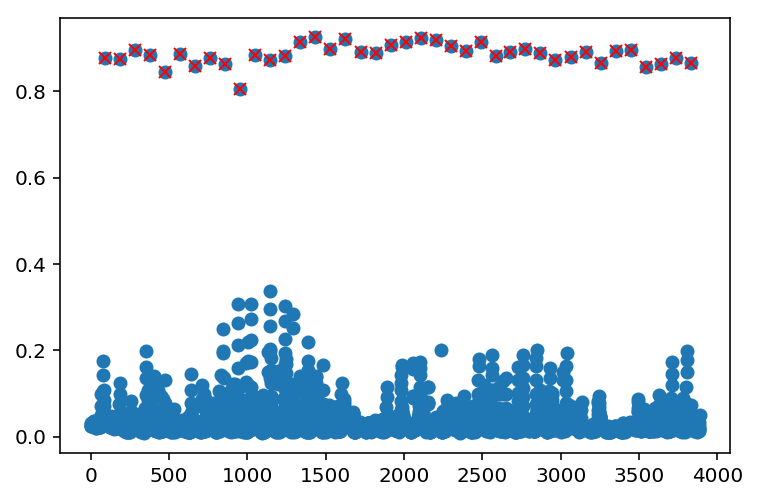

In [11]:
plt.plot(cadn, prob_flux_anomaly, 'o')
plt.plot(cadn[outlier_mask_thruster], prob_flux_anomaly[outlier_mask_thruster], 'rx');

All of the conspicuous flux anomalies arise from known thruster firings.  There are some other cadences that seem to be flagged as anomalous about 30% of the time.  Let's leave them for now.

## PCA preprocessing
### We will "pre-whiten" the lightcurves.

The lightcurves have many disparate flux levels, and standard deviations.

In [12]:
lc_array.shape

(3888, 8380)

In [13]:
def plot_top_n_lightcurves(light_curve_array, top_n=10):
    '''plot the top N lightcurves of an n_cad x n_target array'''
    for i in range(top_n):
        mask = (~outlier_mask_thruster &
                ~sigma_clip_array[:, i].astype(np.bool) &
                ~(prob_flux_anomaly > 0.4))

        plt.step(cadn[mask], light_curve_array[:, i][mask]);
    plt.ylim(0)

We need an $n_{instance} \times n_{feature}$ array for PCA.

In [14]:
lc_white = lc_array.copy().T

In [15]:
lc_white.shape

(8380, 3888)

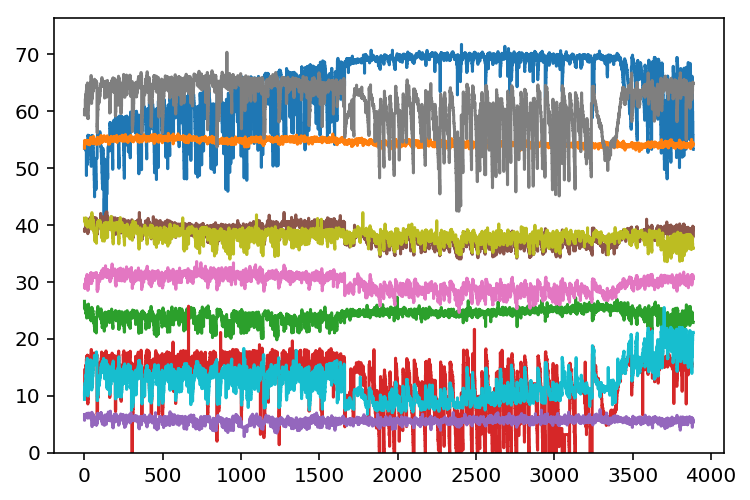

In [16]:
plot_top_n_lightcurves(lc_white.T, 10)

In [17]:
# Normalize all of the lightcurves to an average value of 1
# In order to remove uninteresting correlations

In [18]:
lc_scalars = np.average(lc_white, axis=1)
lc_white = lc_white/lc_scalars[np.newaxis,:].T

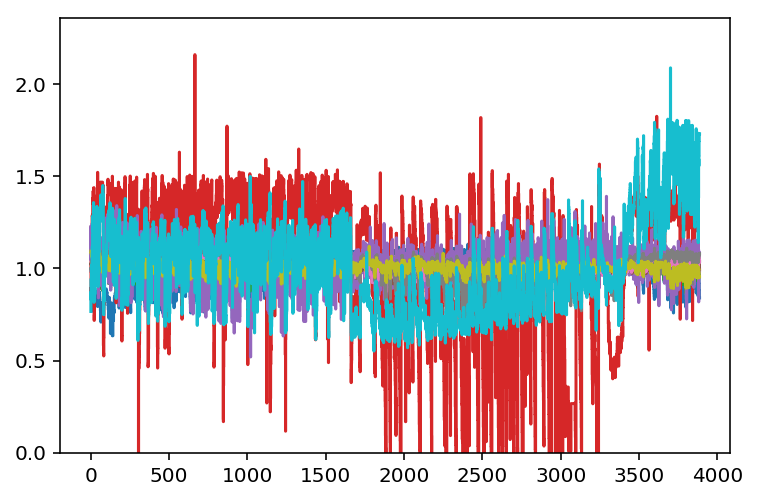

In [19]:
plot_top_n_lightcurves(lc_white.T, 10)

Looks good--- The lightcurves are all normalized.  Next: subtract the mean from all of the lightcurves.

In [20]:
lc_mean = np.average(lc_white, axis=0)
lc_mean.shape
lc_white -= lc_mean

(-3, 3)

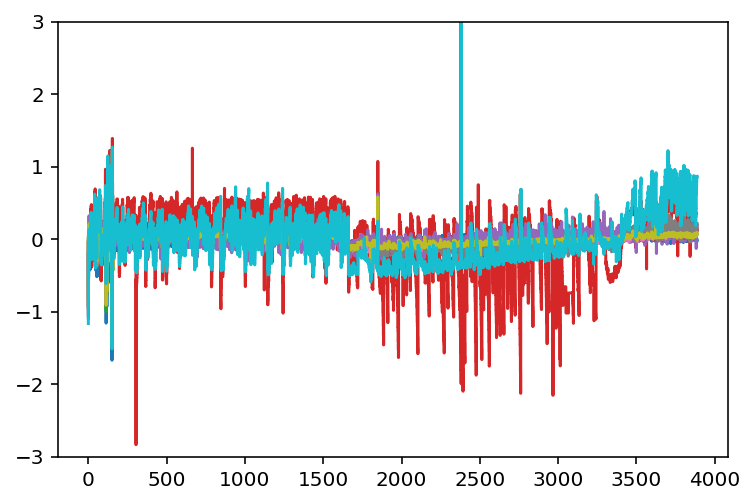

In [21]:
plot_top_n_lightcurves(lc_white.T, 10)
plt.ylim(-3, 3)

(-0.5, 0.5)

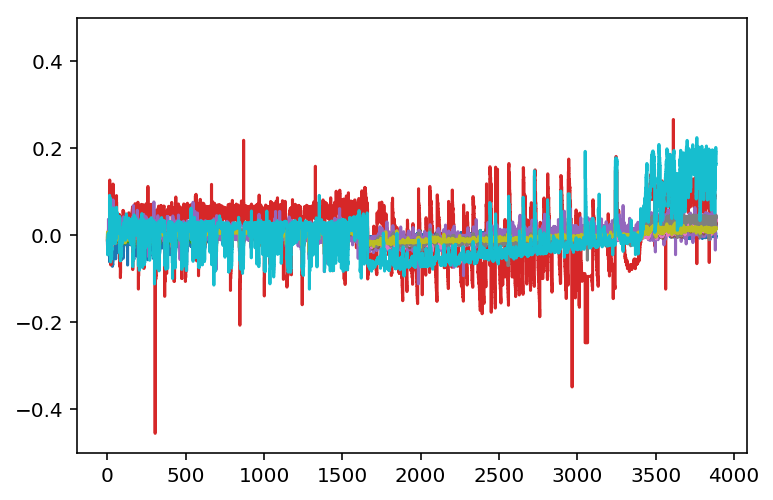

In [22]:
# "Whiten" each spectrum such that the variance for each wavelength is 1
lc_std = np.std(lc_white, axis=0)
lc_white /= lc_std

lc_std.shape

plot_top_n_lightcurves(lc_white.T, 10)
plt.ylim(-0.5, 0.5)

## Perform the PCA

In [23]:
lc_white.shape

(8380, 3888)

This step takes ~2 minutes or less.

In [24]:
%%time
pca = PCA(n_components=0.99)
pca.fit(lc_white)

CPU times: user 1min 36s, sys: 1.74 s, total: 1min 38s
Wall time: 1min 38s


Spot check the results.

In [25]:
comp = pca.transform(lc_white)
components = pca.components_
mean = pca.mean_
variance_ratio = pca.explained_variance_ratio_

ncomp = len(components)

print("found {} components explaining {}% of the" \
      " variance".format(ncomp, 99))

print("Shape of PCA components {}".format(components.shape))

if not np.allclose(mean.T, np.zeros_like(mean)):
    print("PCA mean is more than just numerical noise. Something's wrong!")

found 45 components explaining 99% of the variance
Shape of PCA components (45, 3888)


In [26]:
lc_white.shape

(8380, 3888)

(-0.25, 0.25)

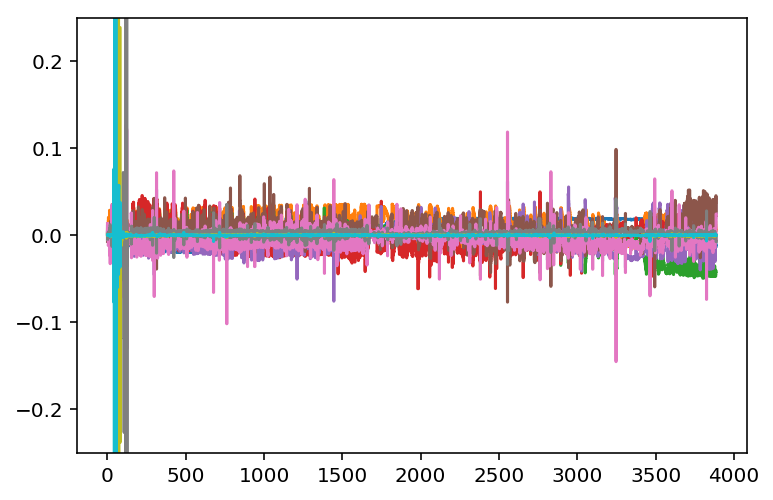

In [27]:
plot_top_n_lightcurves(components.T)
plt.ylim(-0.25, 0.25)

Compute the *eigenweights* of, and reconstruct, the $i=2913^{rd}$ lightcurve.

In [28]:
eigenweights = np.matmul(components, lc_white[2913,:])

In [29]:
components.shape, lc_white[2913, :].shape, eigenweights.shape

((45, 3888), (3888,), (45,))

In [30]:
reconstructed_js = eigenweights*components.T
reconstructed_js.shape

(3888, 45)

(-0.05, 0.05)

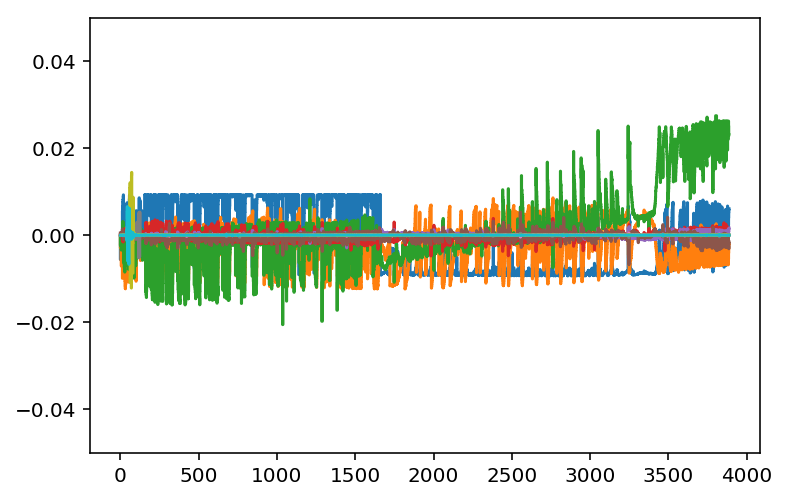

In [31]:
plot_top_n_lightcurves(reconstructed_js)
plt.ylim(-0.05, 0.05)

In [32]:
reconstructed_upto = np.cumsum(reconstructed_js, axis=1)
reconstructed_upto.shape

(3888, 45)

In [33]:
reconstructed_upto[:, 5]

array([-0.00037083, -0.01047301, -0.0072366 , ...,  0.02509035,
        0.02480465,  0.02677007])

In [34]:
mask = ~outlier_mask_thruster
this_lc = lc_white[2913, :][mask]*lc_std[mask]+lc_mean[mask]
clean_recon_upto = reconstructed_upto[cadn[mask], :]*lc_std[mask][:, None]+lc_mean[mask][:, None]

(-1, 2)

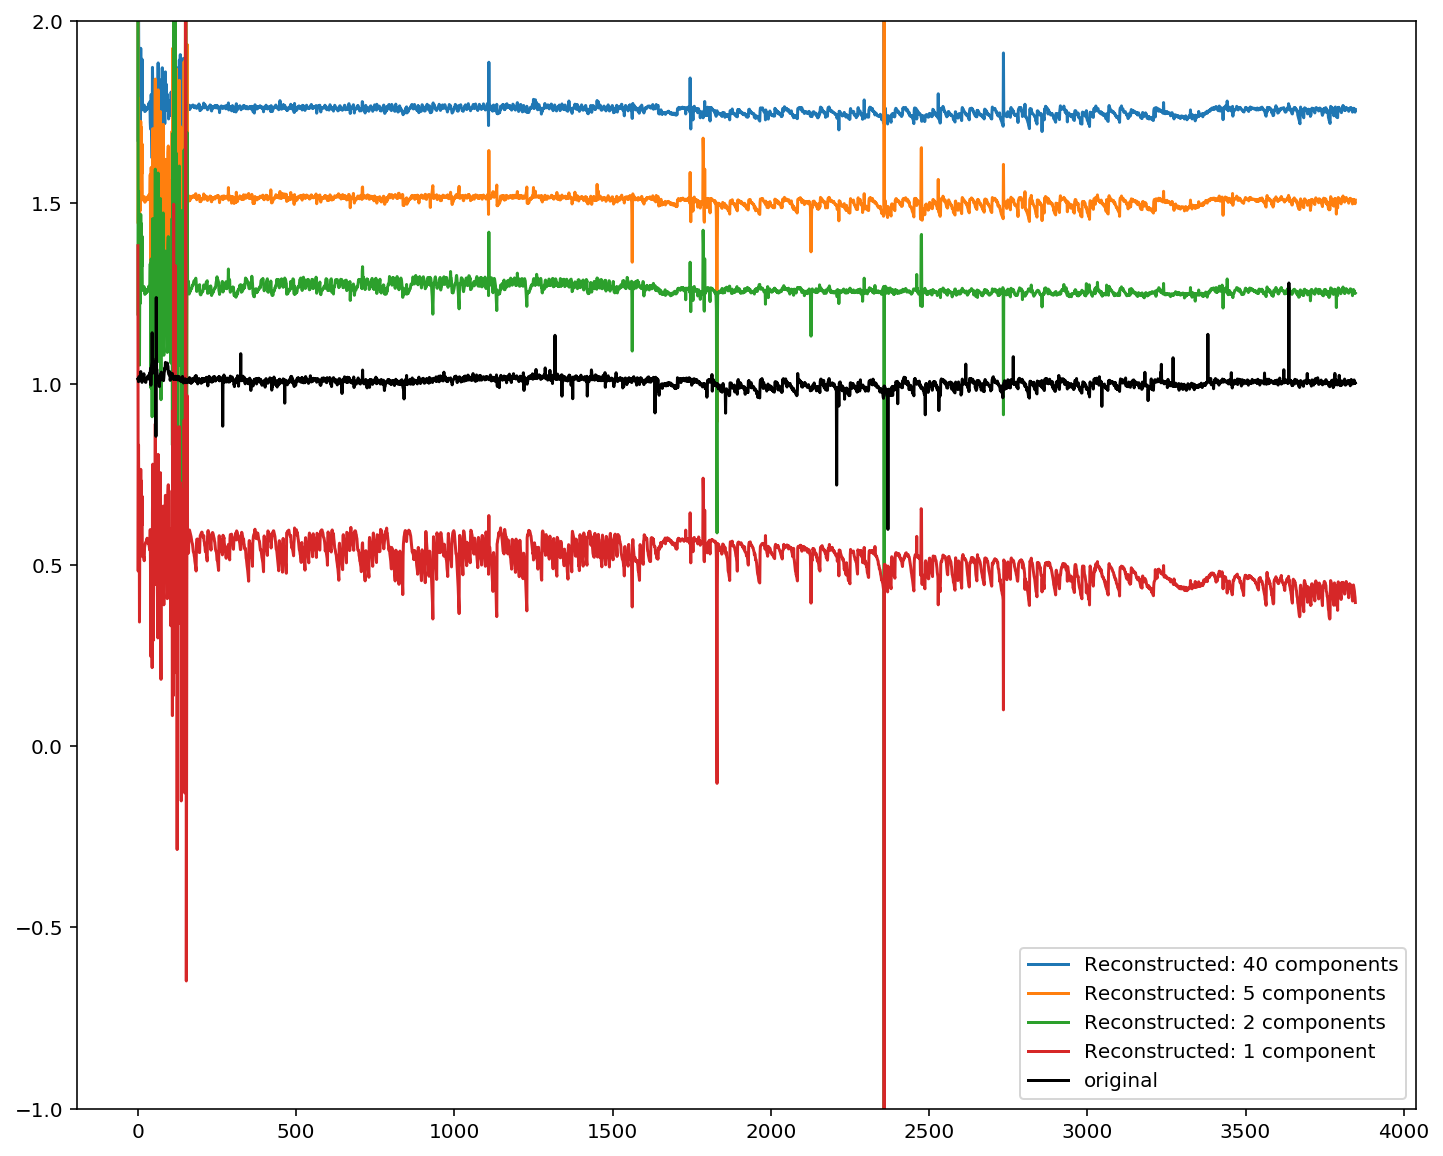

In [36]:
plt.figure(figsize=(12, 10))

plt.plot(0.75+clean_recon_upto[:,40], label='Reconstructed: 40 components')
plt.plot(0.5+clean_recon_upto[:,5], label='Reconstructed: 5 components')
plt.plot(0.25+clean_recon_upto[:,2], label='Reconstructed: 2 components')
plt.plot(-0.5+clean_recon_upto[:,0], label='Reconstructed: 1 component')
plt.plot(this_lc, 'k-', label='original')
plt.legend()
plt.ylim(-1, 2)

OK, those are the reconstructed lightcurves, but that's not exactly what we want yet--- we need to filter, smooth, and iterate to identify the best CBVs.  The paper goes in to lots of detail about the choice of targets, and their intrinsic variability.


It might be worth mimicking https://github.com/rodluger/k2cbv, and/or trying to replicate the [original paper](http://adsabs.harvard.edu/abs/2012PASP..124.1000S), or its [Matlab code](https://github.com/nasa/kepler-pipeline/blob/7bec7056cf5cc325f61b226ebe463b2336737b7c/source-code/matlab/pdc/mfiles/map/map_find_basis_vectors.m)